In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import importlib

import sklearn
#baseline linear regression
from sklearn import linear_model
#import sklearn.linear_model
#normalization
from sklearn import preprocessing
#train/test split
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
#metrics
from sklearn.metrics import mean_absolute_error

#dnn
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import DNN

#keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers

%matplotlib inline

In [2]:
importlib.reload(DNN)

<module 'DNN' from 'C:\\Users\\mircean\\git\\ML\\DeepLearning\\DNN.py'>

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
df1 = pd.read_csv(r'..\Zillow\properties_2016.csv')
print(df1.shape)
df2 = pd.read_csv(r'..\Zillow\train_2016_v2.csv')
print(df2.shape)


C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)
(90275, 3)


In [24]:
#df2[df2.transactiondate >= '2016-10-15']
df2[df2.transactiondate < '2016-10-15'].shape
#max(df2.transactiondate)

(85670, 3)

In [7]:
df_train = df2.merge(df1, how='left', on='parcelid')

#revisit this fillna
df_train = df_train.fillna(0)

df_train['taxdelinquencyflag'] = df_train.taxdelinquencyflag.apply(lambda x: 1 if x == 'Y' else 0 )
df_train['fireplaceflag'] = df_train.hashottuborspa.astype(int)
df_train['hashottuborspa'] = df_train.hashottuborspa.astype(int)

#use all old data for training
#split the new data, 50% train, 50% dev
df_train_1 = df_train[df_train.transactiondate < '2016-10-15']
df_train_2 = df_train[df_train.transactiondate >= '2016-10-15']

train_index, dev_index = train_test_split(df_train_2.index, test_size=0.5, random_state=0)
df_train = pd.concat([df_train_1, df_train_2.loc[train_index]])
df_dev = df_train_2.loc[dev_index]

y_train = df_train.logerror.values
y_dev = df_dev.logerror.values

df_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
df_dev = df_dev.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)

X_train = df_train.values
X_dev = df_dev.values

print(X_train.shape)
print(X_dev.shape)

(87972, 55)
(2303, 55)


In [96]:
df_dev

,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
89398,2016-12-15,0.0,0.0,0.0,1.0,2.0,0.0,7.0,1.0,0.0,...,0.0,0,57315.0,132527.0,2015.0,75212.0,2196.48,1,12.0,6.037531e+13
88713,2016-12-04,0.0,0.0,0.0,2.0,3.0,0.0,7.0,2.0,0.0,...,0.0,0,85328.0,301608.0,2015.0,216280.0,3977.79,0,0.0,6.037571e+13
88288,2016-11-28,0.0,0.0,0.0,1.5,3.0,0.0,0.0,1.5,0.0,...,1.0,0,41357.0,65393.0,2015.0,24036.0,959.50,0,0.0,6.059076e+13
88177,2016-11-23,1.0,0.0,0.0,3.0,3.0,0.0,1.0,3.0,0.0,...,0.0,0,282942.0,393929.0,2015.0,110987.0,4822.58,0,0.0,6.037578e+13
85840,2016-10-19,0.0,0.0,0.0,1.0,3.0,0.0,7.0,1.0,0.0,...,0.0,0,90764.0,122605.0,2015.0,31841.0,2253.54,0,0.0,6.037901e+13
86902,2016-11-03,0.0,0.0,0.0,3.0,4.0,0.0,4.0,3.0,0.0,...,0.0,0,86269.0,150300.0,2015.0,64031.0,2315.44,0,0.0,6.037671e+13
89874,2016-12-23,0.0,0.0,0.0,3.0,4.0,0.0,4.0,3.0,0.0,...,0.0,0,69337.0,135817.0,2015.0,66480.0,1904.86,0,0.0,6.037142e+13
86201,2016-10-24,1.0,0.0,0.0,3.0,3.0,0.0,4.0,3.0,0.0,...,0.0,0,247688.0,561218.0,2015.0,313530.0,6976.40,0,0.0,6.037124e+13
86252,2016-10-25,1.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,0.0,...,0.0,0,207656.0,368730.0,2015.0,161074.0,5287.01,0,0.0,6.037920e+13
87160,2016-11-08,0.0,0.0,0.0,2.0,3.0,0.0,0.0,2.0,0.0,...,1.0,0,119752.0,371112.0,2015.0,251360.0,4351.92,0,0.0,6.059002e+13


In [8]:
#normalization - mean, var from train set, apply to dev set and test set
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)   
X_dev = scaler.transform(X_dev)

X_train_k = X_train
X_dev_k = X_dev
Y_train_k = y_train.reshape(y_train.shape[0], 1)
Y_dev_k = y_dev.reshape(y_dev.shape[0], 1)

X_train_my = X_train.T
X_dev_my = X_dev.T
Y_train_my = y_train.reshape(1, y_train.shape[0])
Y_dev_my = y_dev.reshape(1, y_dev.shape[0])



In [9]:
np.random.seed(0) # set a seed so that the results are consistent
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)
print(mean_absolute_error(y_train, y_pred))
y_pred = regr.predict(X_dev)
print(mean_absolute_error(y_dev, y_pred))

0.0683074122879
0.0710661821951


In [21]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, verbose):
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose != None and epoch % self.verbose == 0:
            print(epoch, logs['loss'], logs['mean_absolute_error'], logs['val_mean_absolute_error']) 

In [29]:
np.random.seed(0)
model = Sequential()
initializer = keras.initializers.lecun_normal()
regularizer = None
model.add(Dense(50, input_dim=X_train_k.shape[1], kernel_initializer=initializer, activation='relu', kernel_regularizer=regularizer))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
optimizer = optimizers.SGD(lr=0.05)
#optimizer = optimizers.Adam(lr=0.05)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

In [30]:
np.random.seed(0) 
initial_epoch = 0
epochs = 1000
verbose = 0
verbose2 = 10
#batch_size = int(X_train_k.shape[0])
batch_size = 256
results = model.fit(X_train_k, Y_train_k, batch_size=batch_size, epochs=epochs, callbacks=[MyCallback(verbose2)], validation_data = (X_dev_k, Y_dev_k), verbose=verbose, initial_epoch=initial_epoch)
Y_predict_k = model.predict(X_train_k)
print(mean_absolute_error(Y_train_k, Y_predict_k))
Y_predict_k = model.predict(X_dev_k)
print(mean_absolute_error(Y_dev_k, Y_predict_k))

0 0.0260000825973 0.0684128404592 0.070789546085
10 0.025977811207 0.0683633645872 0.0706883720145
20 0.0259535648177 0.0683223063215 0.0706916796873
30 0.0259272838426 0.0683307302183 0.0709867342931
40 0.0259039175634 0.0683673748737 0.0709169695895
50 0.0258833236556 0.0684031058247 0.0709625178033
60 0.0258646371603 0.068425595596 0.071121081946
70 0.0258476565064 0.0684905647996 0.0710427475769
80 0.0258299009929 0.0684998396841 0.0712129309761
90 0.0258149079935 0.0684952461466 0.0711144003152
100 0.0257963549707 0.0685421290997 0.0712282139544
110 0.025783168213 0.0685063231002 0.0711760447335
120 0.0257718358274 0.0685483824621 0.0712741127531
130 0.0257591751353 0.0686058007038 0.0713624244655
140 0.0257470222579 0.0685834207387 0.0713954285868
150 0.0257337337017 0.0685966686275 0.0715007576355
160 0.0257241891185 0.0686030334222 0.0713303003087
170 0.025711932625 0.0686242098824 0.0714108651772
180 0.025697478661 0.0686407330446 0.0714286231265
190 0.025682261096 0.068653969

In [ ]:
50/20/20/1 0.05/1000/batch
0.068418922444
0.0707010474982

50/20/20/1 0.05/1000/256
0.0713863738691
0.0779876377184

In [128]:
results.history['loss'][0], results.history['loss'][-1]

(0.025974750518798828, 0.025956157594919205)

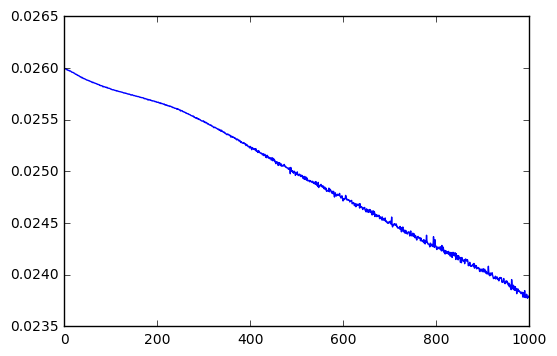

In [31]:
plt.plot(results.history['loss'])
plt.show()

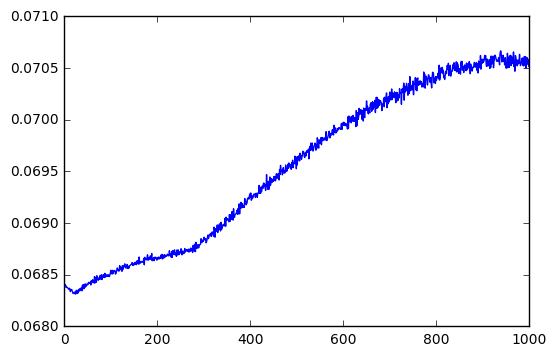

In [32]:
plt.plot(results.history['mean_absolute_error'])
plt.show()

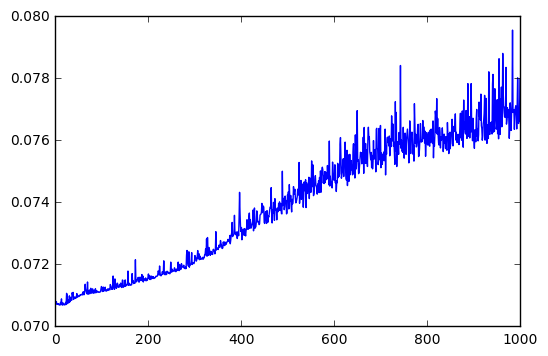

In [33]:
plt.plot(results.history['val_mean_absolute_error'])
plt.show()

In [34]:
importlib.reload(DNN)

<module 'DNN' from 'C:\\Users\\mircean\\git\\ML\\DeepLearning\\DNN.py'>

In [43]:
#random seed for parameters init
np.random.seed(0)
dnn = DNN.DNN()
dnn.add_input_layer(X_train_my.shape[0])
dnn.add_layer(50, DNN.relu)
dnn.add_layer(20, DNN.relu)
dnn.add_layer(20, DNN.relu)
dnn.add_layer(1, DNN.identity)
dnn.costfunction = DNN.mean_squared_error
dnn.init = 'He'
dnn.compile()

In [ ]:
#random seed for mini batch shuffle
np.random.seed(0) 

learning_rate = 0.05
num_iterations = 1000
batch_size = 256
verbose = 10
gradient_check=False
#num_parameters = 2500

#eval_set = None
eval_set = [(X_train_my, Y_train_my), (X_dev_my, Y_dev_my)]
results = dnn.fit(X_train_my, Y_train_my, eval_set=eval_set, eval_metric='mae', learning_rate=learning_rate, num_iterations=num_iterations, batch_size=batch_size, gradient_check=gradient_check, verbose=verbose)
Y_predict_my = dnn.predict(X_train_my)
print(mean_absolute_error(np.reshape(Y_train_my, Y_train_my.shape[1]), np.reshape(Y_predict_my, Y_predict_my.shape[1])))
Y_predict_my = dnn.predict(X_dev_my)
print(mean_absolute_error(np.reshape(Y_dev_my, Y_dev_my.shape[1]), np.reshape(Y_predict_my, Y_predict_my.shape[1])))


........................................................................................................................................................................................................................................................................................................................................................
Cost after iteration 0 ['0.025683', '0.068630', '0.072365']
........................................................................................................................................................................................................................................................................................................................................................
Cost after iteration 10 ['0.025655', '0.069202', '0.072508']
.............................................................................................................................................................................................

In [ ]:
#results
1K train/dev mae 68.385, 70.723
10K 68.373 70.717
Keras
68.297, 70.754

In [150]:
results['eval0'][-1]

0.068385968578286049

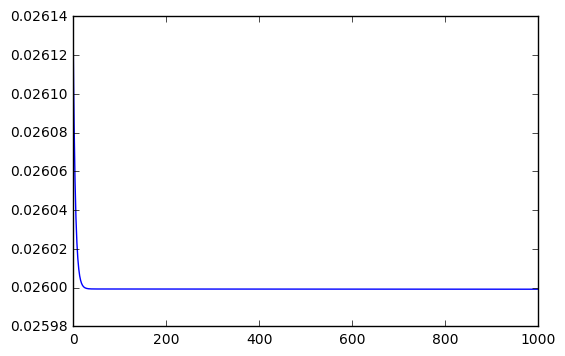

In [146]:
plt.plot(results['loss'])
plt.show()

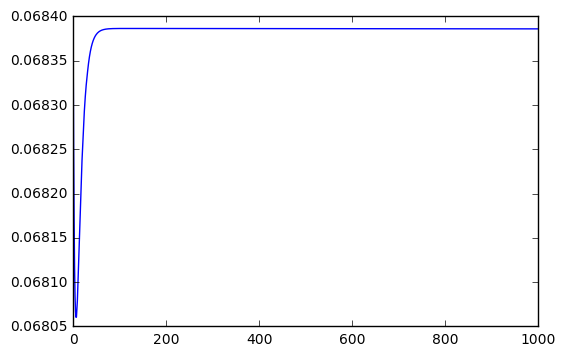

In [147]:
plt.plot(results['eval0'])
plt.show()

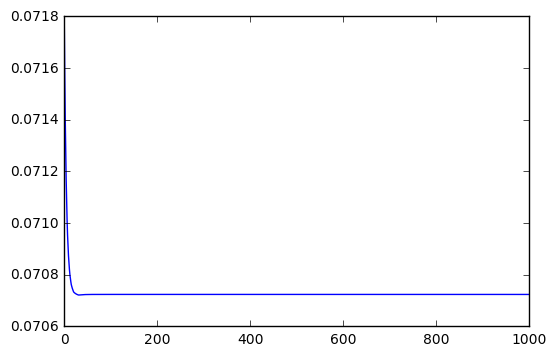

In [148]:
plt.plot(results['eval1'])